In [23]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/RadarData/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import colors
import data_preprocessing

In [0]:
# !!! ONLY LOAD DATA THAT ARE FOLLOWING EACH OTHER IN TIME !!!

zone = "NW"    # NW
years = [2016]    # 2016, 2017 or 2018
months = [1]
part_months = [3] # Choice between 1,2,3, as we said earlier each month is divided in 3 parts
#min and max indexes when the dataset is loaded in memory
ind_min = None # or values such as ind_min < ind_max and they must be within the range of the number of data that you are trying to download
ind_max = None
new_size = [64,64]

directory = '/content/drive/My Drive/CS231N/Project/MeteoNet_dataset/meteonet_dataset/'
[lat, lon] = data_preprocessing.get_coords(directory, zone)
data = data_preprocessing.data_preprocess(directory, years, months, part_months, zone, new_size, ind_min, ind_max)


In [19]:
data_preprocessing.data_preprocess()

AttributeError: ignored

In [0]:
X, y = multivariate_data(data, 0, None, 19)
N, F, H, W, C = X.shape
print(X.shape)
print(y.shape)
X = tf.cast(X, tf.float32)
y = tf.cast(y, tf.float32)

(159, 19, 64, 64, 1)
(159, 19, 64, 64, 1)


In [0]:
# Our Model Architecture
def model_init(input_shape, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    CL1 = tf.keras.layers.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=True)(inputs)
    CL2 = tf.keras.layers.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=True)(CL1)
    # Decoder
    CL3 = tf.keras.layers.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=True)(CL1)
    added = tf.keras.layers.Add()([CL2, CL3])
    CL4 = tf.keras.layers.ConvLSTM2D(filters, kernel_size, padding='same', return_sequences=True)(added)
    # Prediction
    concat = tf.keras.layers.Concatenate()([CL3, CL4])
    preds = tf.keras.layers.Conv3D(1, 1, activation='sigmoid', padding='same')(concat)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Initialize model
model = model_init([None, H, W, C], 64, 5)
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mse',
              metrics=['acc'])
# Fit the model
history = model.fit(X, y, batch_size=3, epochs=3, validation_split=0.1)

Epoch 1/3
48/48 [==============================] - 93s 2s/step - loss: 0.0351 - acc: 0.8426 - val_loss: 0.0063 - val_acc: 0.9116
Epoch 2/3
48/48 [==============================] - 92s 2s/step - loss: 0.0058 - acc: 0.8597 - val_loss: 0.0030 - val_acc: 0.9122
Epoch 3/3
48/48 [==============================] - 92s 2s/step - loss: 0.0044 - acc: 0.8601 - val_loss: 0.0024 - val_acc: 0.9125


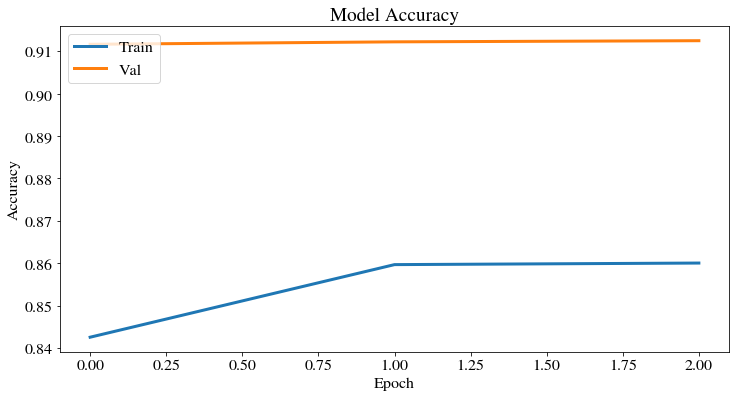

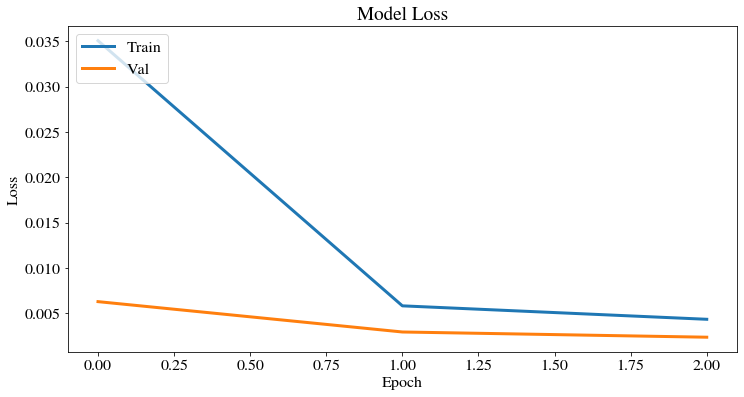

In [0]:
# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('accuracy.png')
# files.download('accuracy.png')

# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('loss.png')
# files.download('loss.png')

In [0]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 50
init_traj = 10
pred_traj = X.shape[1] - init_traj
track = X[itest, :init_traj, :, :, :]
for i in range(pred_traj):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos[:, -1, :, :, :]), axis=0)
print("track:", track.shape)

track: (19, 64, 64, 1)


IndexError: ignored

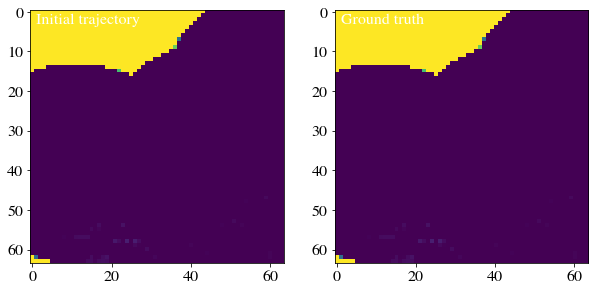

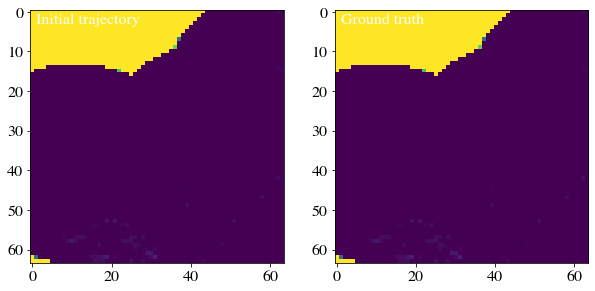

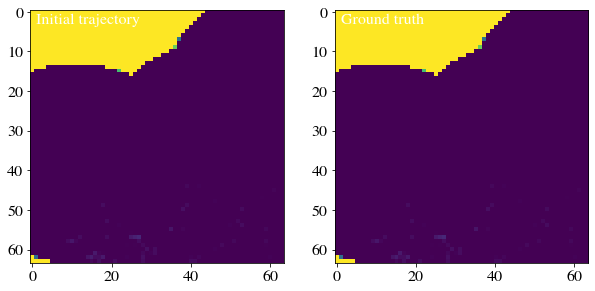

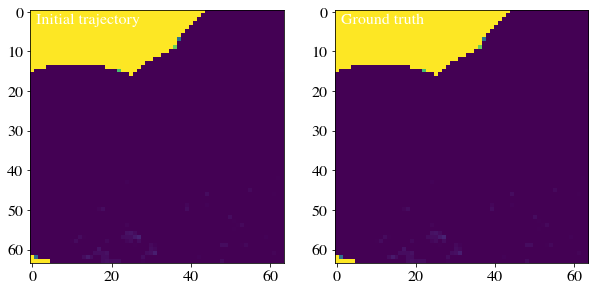

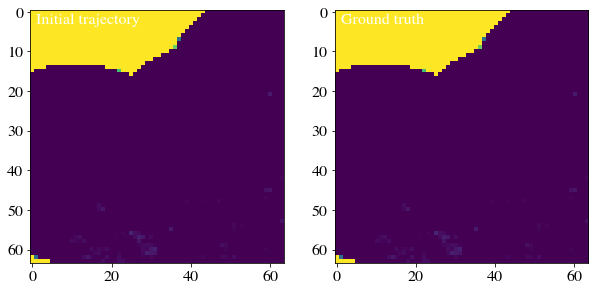

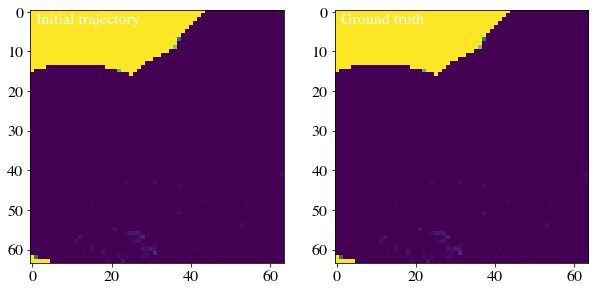

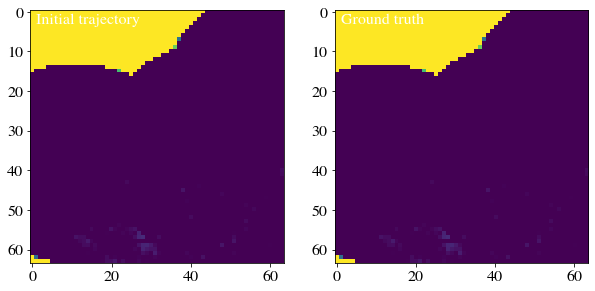

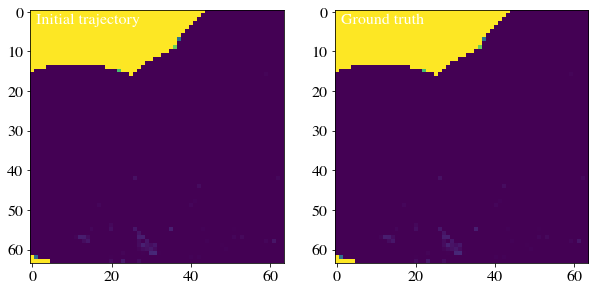

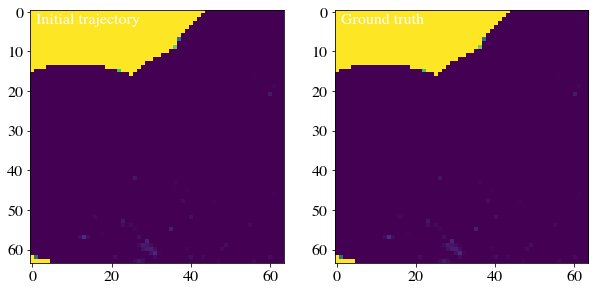

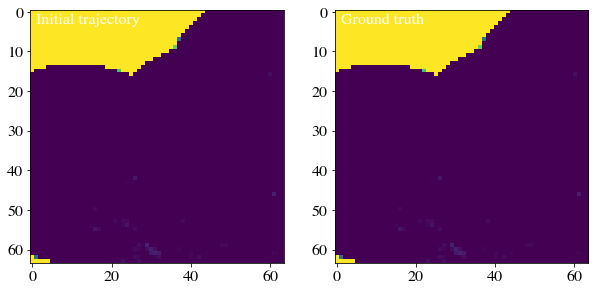

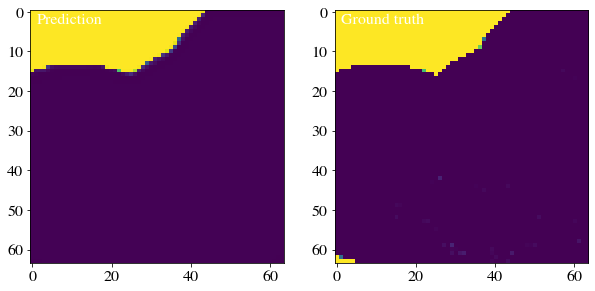

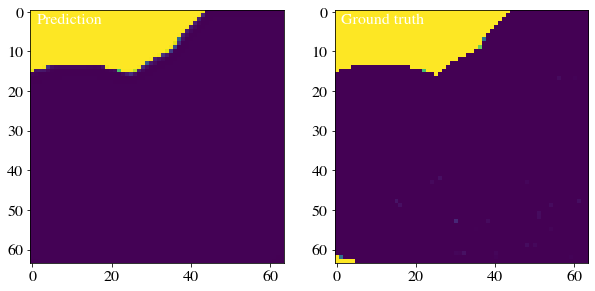

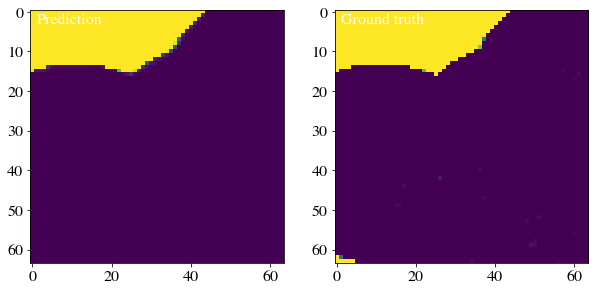

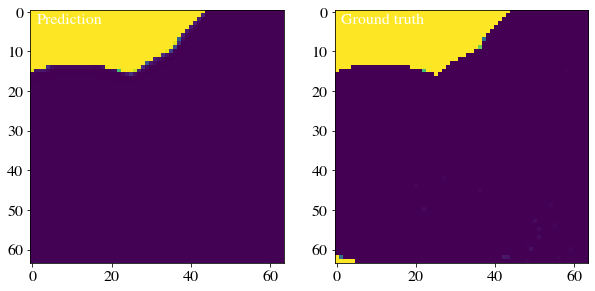

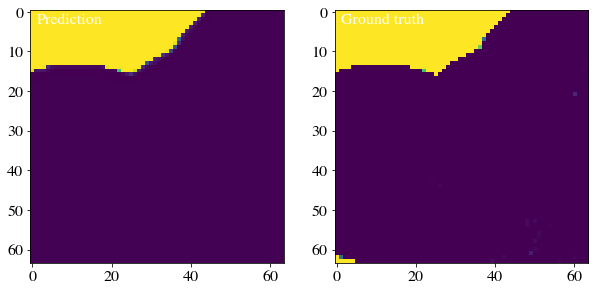

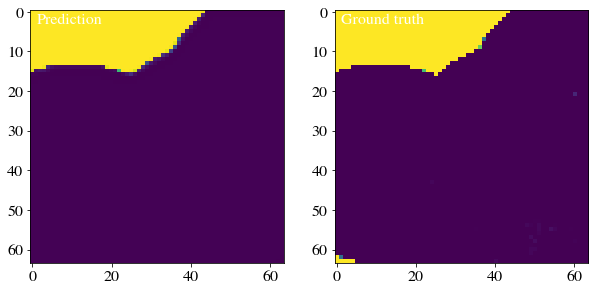

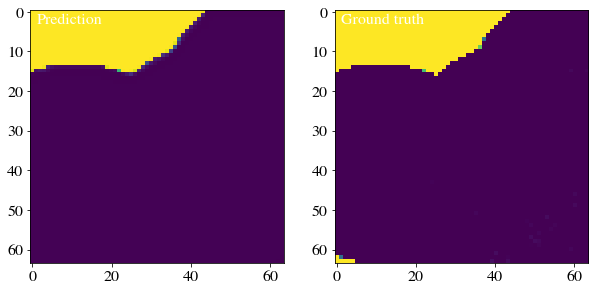

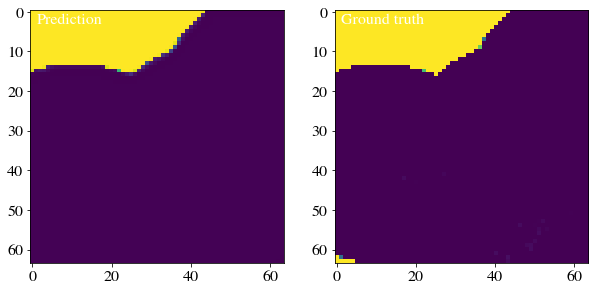

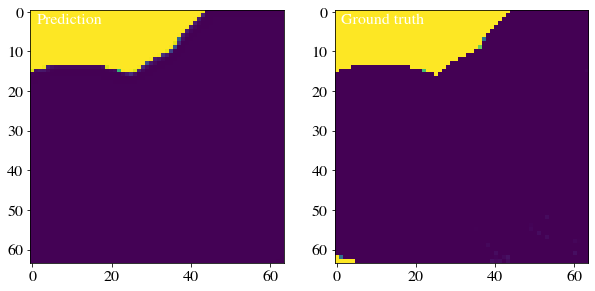

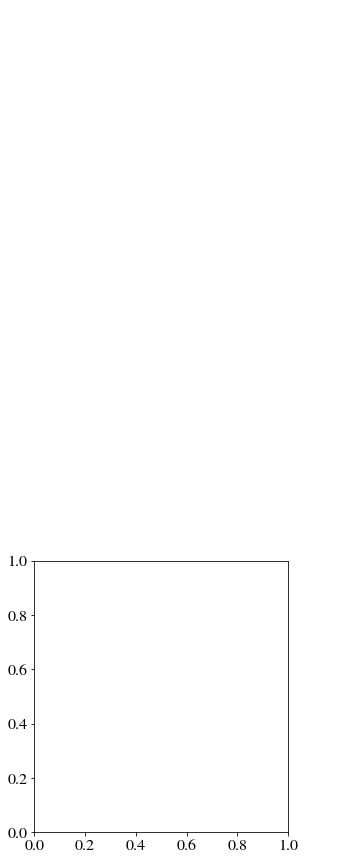

In [0]:
# Plot results
true_track = X[itest, :, :, :, 0]

for i in range(20):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= init_traj:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :])

    # plt.savefig('anim_%i.png' % (i+1))
    # files.download('anim_%i.png' % (i+1))